In [135]:
import wandb

# Initialize API (make sure you're logged in or set the API key)
wandb.login()

# Replace with your entity, project, and run ID
api = wandb.Api()

# Get all runs of the project that didn't crash
runs = api.runs(
    "rl-sunflower/tabpfn-time-series",
    # filters={"$and": [{"state": "finished"}, {"group": {"$in": ["11546127", "11548929"]}}]}
    filters={"group": {"$in": [
        "11550610",     # Seasonal Naive
        "11549116",     # Vanilla TabPFN
        "11612932",     # Autogluon (without Chronos)
    ]}},   
)


In [136]:
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed

import pandas as pd

def fetch_run_data(run):
    history = run.history()
    
    if len(history) > 1:
        # get the first row
        history = history.iloc[-1:]
    return history

# time the following code
import time
start = time.time()

all_runs_data = []
with ThreadPoolExecutor(max_workers=8) as executor:  # Adjust 'max_workers' based on your network conditions
    futures = [executor.submit(fetch_run_data, run) for run in runs]
    for future in tqdm(as_completed(futures), total=len(futures)):
        all_runs_data.append(future.result())

df_all_runs = pd.concat(all_runs_data)
print("df_all_runs.shape:", df_all_runs.shape)

print(f"Time taken: {time.time() - start:.2f} seconds")

100%|██████████| 87/87 [00:05<00:00, 16.58it/s]


df_all_runs.shape: (87, 27)
Time taken: 6.30 seconds


In [137]:
df_all_runs

,utc,id,job_id,predict_duration,mode,app_version,training_duration,_timestamp,params,metric,...,task,benchmark,log,_runtime,framework,seed,_step,result,fold,models_count
13,2024-06-12T11:25:09,web_traffic_weekly,None,779.7,local,dev [git@github.com:liam-sbhoo/automlbenchmark...,5373.7,1.718192e+09,NaN,neg_mase,...,web_traffic_weekly,None,None,6803.205924,AutoGluon,0.0,13,-0.933587,0.0,11.0
13,2024-06-12T09:42:10,vehicle_trips,None,104.7,local,dev [git@github.com:liam-sbhoo/automlbenchmark...,675.6,1.718185e+09,NaN,neg_mase,...,vehicle_trips,None,None,849.952024,AutoGluon,0.0,13,-1.11436,0.0,12.0
9,NaN,NaN,None,NaN,NaN,NaN,NaN,1.718184e+09,NaN,NaN,...,None,None,Running task nn5_weekly on framework AutoGluon...,4.603595,None,NaN,9,NaN,NaN,NaN
9,NaN,NaN,None,NaN,NaN,NaN,NaN,1.718184e+09,NaN,NaN,...,None,None,Running task nn5_daily on framework AutoGluon ...,4.846378,None,NaN,9,NaN,NaN,NaN
13,2024-06-12T09:32:44,tourism_quarterly,None,79.0,local,dev [git@github.com:liam-sbhoo/automlbenchmark...,467.3,1.718185e+09,NaN,neg_mase,...,tourism_quarterly,None,None,646.670896,AutoGluon,0.0,13,-1.53004,0.0,12.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13,2024-06-02T17:53:18,kdd_cup_2018,None,541.2,local,dev [git@github.com:liam-sbhoo/automlbenchmark...,0.0,1.717351e+09,NaN,neg_mase,...,kdd_cup_2018,None,None,568.150436,TabPFN,0.0,13,-0.941433,0.0,1.0
13,2024-06-02T17:50:30,hospital,None,387.0,local,dev [git@github.com:liam-sbhoo/automlbenchmark...,0.0,1.717351e+09,NaN,neg_mase,...,hospital,None,None,401.266330,TabPFN,0.0,13,-0.820611,0.0,1.0
13,2024-06-02T18:04:57,electricity_hourly,None,1242.0,local,dev [git@github.com:liam-sbhoo/automlbenchmark...,0.0,1.717351e+09,NaN,neg_mase,...,electricity_hourly,None,None,1268.362505,TabPFN,0.0,13,-2.68729,0.0,1.0
13,2024-06-02T17:45:20,fred_md,None,80.5,local,dev [git@github.com:liam-sbhoo/automlbenchmark...,0.0,1.717350e+09,NaN,neg_mase,...,fred_md,None,None,90.612557,TabPFN,0.0,13,-0.525854,0.0,1.0


In [138]:
# Preprocess data (convert to float, NaN value -> inf)
numerical_cols = ['mase', 'wql', 'duration', 'result']
for col in numerical_cols:
    df_all_runs[col] = df_all_runs[col].astype(float)
    df_all_runs[col] = df_all_runs[col].fillna(float('inf'))

In [139]:
# tabpfn_runs = df_all_runs[df_all_runs["framework"] == "TabPFN"]
df_sorted = df_all_runs.sort_values(by='task')

# drop index
df_sorted.reset_index(drop=True, inplace=True)

# Plotting

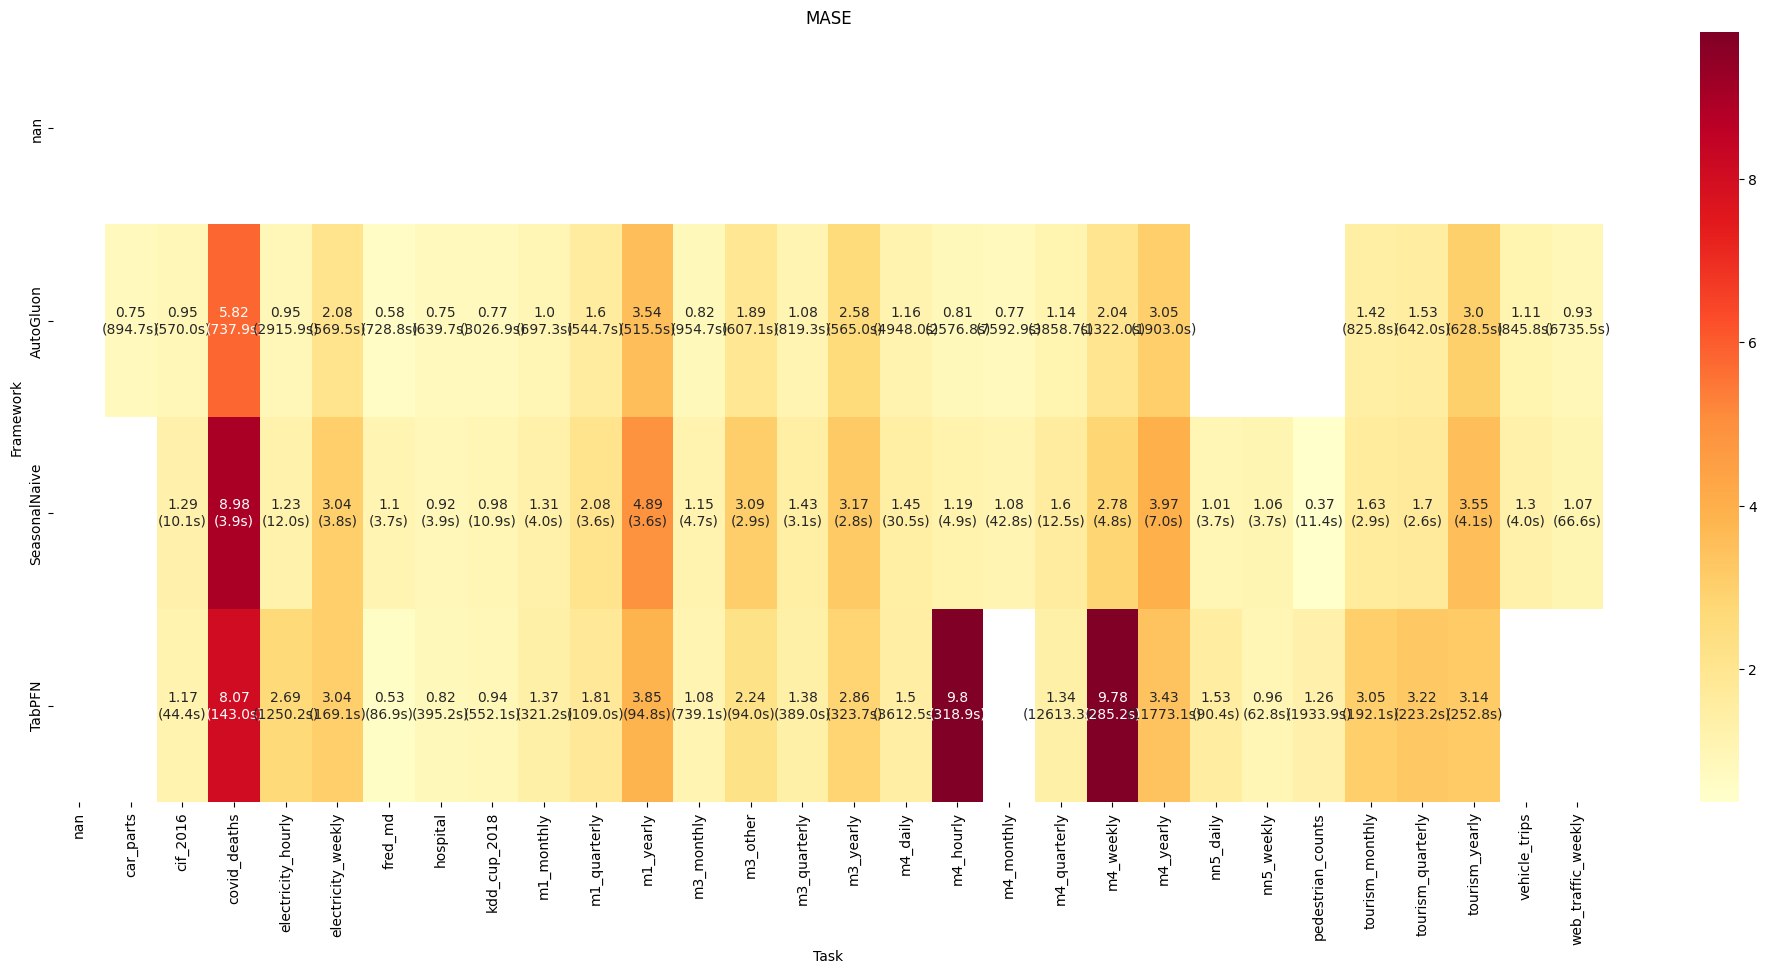

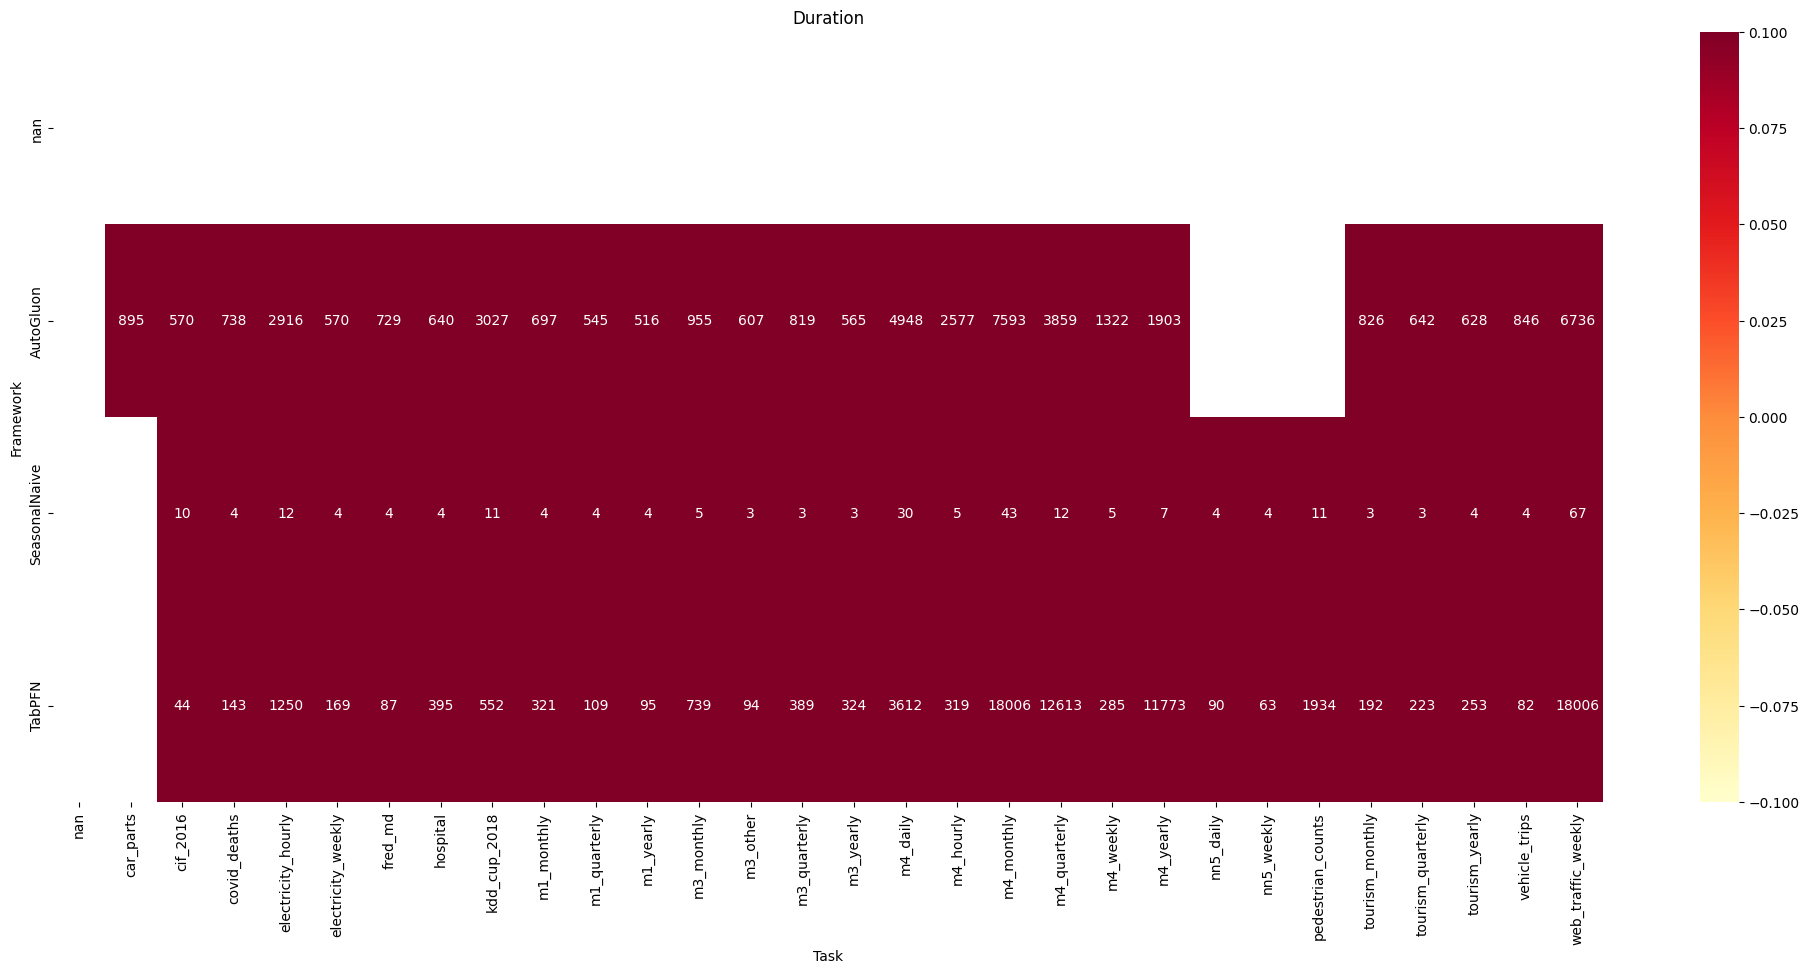

In [140]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the same data with heatmap (mase as color)
#  - y-axis: frameworks
#  - x-axis: tasks

# Get relevant columns only
df_rel = df_sorted[['framework', 'task', 'mase', 'wql', 'duration']]
df_rel = df_rel.drop_duplicates(subset=["framework", "task"], keep='first')

# Pivot the data and create a dataframe with random values
df_mase_pivot = df_rel.pivot(index='framework', columns='task', values='mase').astype(float).replace(float('inf'), float('nan'))
df_random_pivot = pd.DataFrame(np.random.rand(*df_mase_pivot.shape), index=df_mase_pivot.index, columns=df_mase_pivot.columns)

# Customized annotation (each cell shuold be value of mase and total duration as a subtext)
df_duration = df_rel.pivot(index='framework', columns='task', values='duration').astype(float)
df_mase_annot = df_mase_pivot.round(2).astype(str) + f"\n(" + df_duration.astype(str) + "s)"

def plot_heatmap(data, title, xlabel, ylabel, annot_format=".0f", cmap='YlOrRd', annot=True):
    """
    Plots a heatmap for given data.

    Parameters:
    - data: DataFrame containing the data to be plotted.
    - title: str, title of the heatmap.
    - xlabel: str, label for the x-axis.
    - ylabel: str, label for the y-axis.
    - annot_format: str, format string for annotations.
    - cmap: str, colormap used for heatmap.
    - annot: bool, whether to annotate cells.
    """
    plt.figure(figsize=(25, 10))
    sns.heatmap(data, cmap=cmap, annot=annot, fmt=annot_format)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(False)
    plt.show()

# Example usage with MASE data
plot_heatmap(df_mase_pivot, "MASE", "Task", "Framework", "s", annot=df_mase_annot)

# Example usage with Duration data
plot_heatmap(df_duration, "Duration", "Task", "Framework", ".0f")




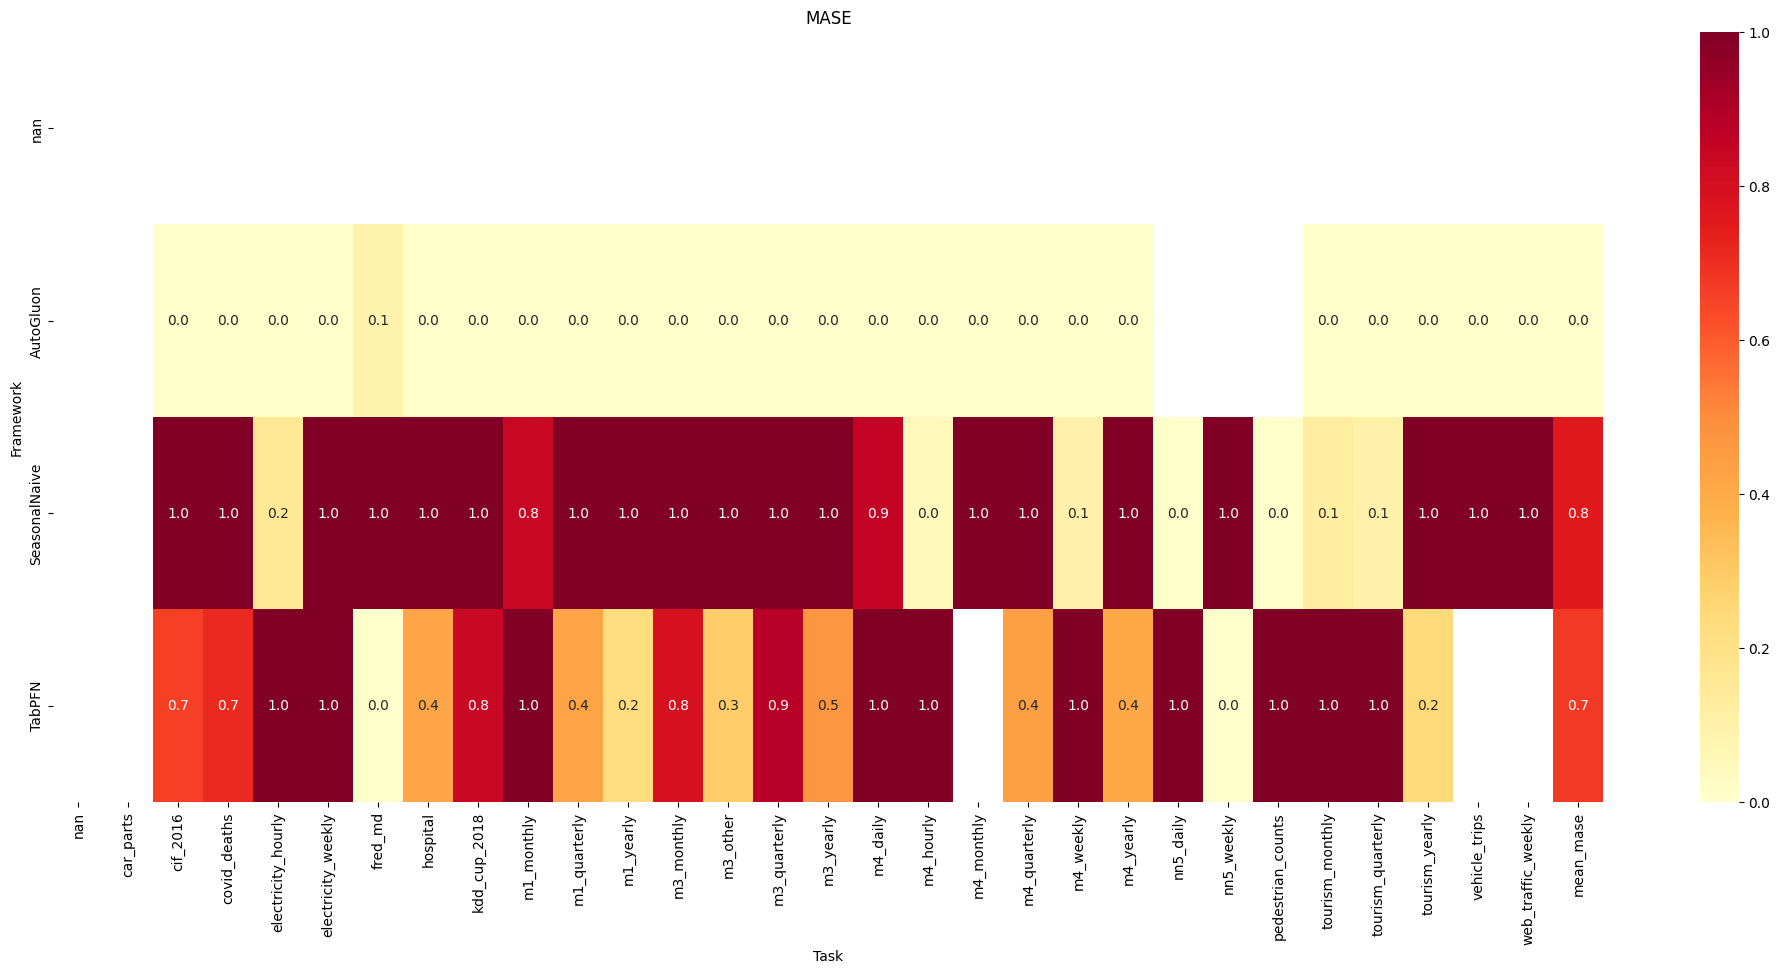

In [141]:
def min_max_scaling(series):
    return (series - series.min()) / (series.max() - series.min())

df_mase_pivot_scaled = df_mase_pivot.apply(min_max_scaling, axis=0)
df_mase_pivot_scaled['mean_mase'] = df_mase_pivot_scaled.mean(axis=1)

plot_heatmap(df_mase_pivot_scaled, "MASE", "Task", "Framework", annot_format=".1f")


In [142]:
df_mase_pivot.head()

task,NaN,car_parts,cif_2016,covid_deaths,electricity_hourly,electricity_weekly,fred_md,hospital,kdd_cup_2018,m1_monthly,...,m4_weekly,m4_yearly,nn5_daily,nn5_weekly,pedestrian_counts,tourism_monthly,tourism_quarterly,tourism_yearly,vehicle_trips,web_traffic_weekly
framework,,,,,,,,,,,,,,,,,,,,,
NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AutoGluon,NaN,0.747569,0.94596,5.82106,0.954103,2.07741,0.579001,0.749823,0.771554,1.00072,...,2.03513,3.05226,NaN,NaN,NaN,1.42473,1.53004,3.00493,1.11436,0.933587
SeasonalNaive,NaN,NaN,1.28929,8.97736,1.230110,3.03717,1.100800,0.920528,0.975216,1.31446,...,2.77730,3.96595,1.01128,1.062850,0.369195,1.63094,1.69899,3.55201,1.30223,1.065710
TabPFN,NaN,NaN,1.17199,8.06867,2.687290,3.04027,0.525854,0.820611,0.941433,1.37408,...,9.78028,3.42689,1.52775,0.959512,1.260750,3.05386,3.22448,3.13795,NaN,NaN


In [143]:
import numpy as np

N_ROW = 10
N_COL = df_mase_pivot.shape[1]

# Create frameworks from random strings
frameworks = [f"framework_{i}" for i in range(N_ROW)]

df_random_pivot = pd.DataFrame(np.random.rand(N_ROW, N_COL), columns=df_mase_pivot.columns, index=frameworks)
df_random_pivot.index.name = "framework"


In [144]:
df_random_pivot

task,NaN,car_parts,cif_2016,covid_deaths,electricity_hourly,electricity_weekly,fred_md,hospital,kdd_cup_2018,m1_monthly,...,m4_weekly,m4_yearly,nn5_daily,nn5_weekly,pedestrian_counts,tourism_monthly,tourism_quarterly,tourism_yearly,vehicle_trips,web_traffic_weekly
framework,,,,,,,,,,,,,,,,,,,,,
framework_0,0.027408,0.800742,0.552681,0.117734,0.372881,0.072117,0.043639,0.885113,0.270471,0.985677,...,0.278742,0.466056,0.948376,0.388708,0.896250,0.008551,0.901300,0.342616,0.346627,0.363256
framework_1,0.038651,0.018155,0.924079,0.201574,0.468397,0.624258,0.066713,0.171691,0.185318,0.633913,...,0.952502,0.699286,0.671732,0.317129,0.636782,0.803821,0.070221,0.528419,0.507124,0.139315
framework_2,0.141541,0.086567,0.722579,0.955704,0.876557,0.038014,0.235473,0.012656,0.730420,0.678540,...,0.828928,0.871194,0.937721,0.134145,0.991248,0.889456,0.770897,0.029872,0.341786,0.572266
framework_3,0.408624,0.210853,0.779441,0.589197,0.310863,0.386164,0.248729,0.577712,0.559291,0.339721,...,0.610156,0.875979,0.159002,0.299174,0.639939,0.778184,0.306724,0.469009,0.492808,0.902358
framework_4,0.293350,0.296219,0.436250,0.510180,0.515401,0.505053,0.773525,0.556953,0.846109,0.217454,...,0.904148,0.305349,0.924270,0.699695,0.540803,0.623130,0.174807,0.134178,0.081918,0.071363
framework_5,0.502966,0.152592,0.439562,0.949300,0.933810,0.445634,0.156417,0.265451,0.252647,0.710992,...,0.165938,0.642689,0.323222,0.096994,0.923221,0.882947,0.546627,0.976717,0.729081,0.954029
framework_6,0.807435,0.532853,0.161881,0.588068,0.747663,0.529597,0.708647,0.334148,0.751262,0.514903,...,0.164422,0.731951,0.803410,0.494690,0.626987,0.627881,0.857488,0.456985,0.311106,0.603212
framework_7,0.040480,0.845259,0.796061,0.035281,0.024541,0.010956,0.187902,0.018920,0.298080,0.536463,...,0.014273,0.953969,0.015059,0.064225,0.723860,0.255976,0.755771,0.226892,0.777347,0.379522
framework_8,0.844769,0.557472,0.649436,0.830002,0.517928,0.483513,0.771608,0.272841,0.818051,0.392612,...,0.871023,0.687111,0.537079,0.773453,0.277469,0.680509,0.128419,0.351523,0.674376,0.015388


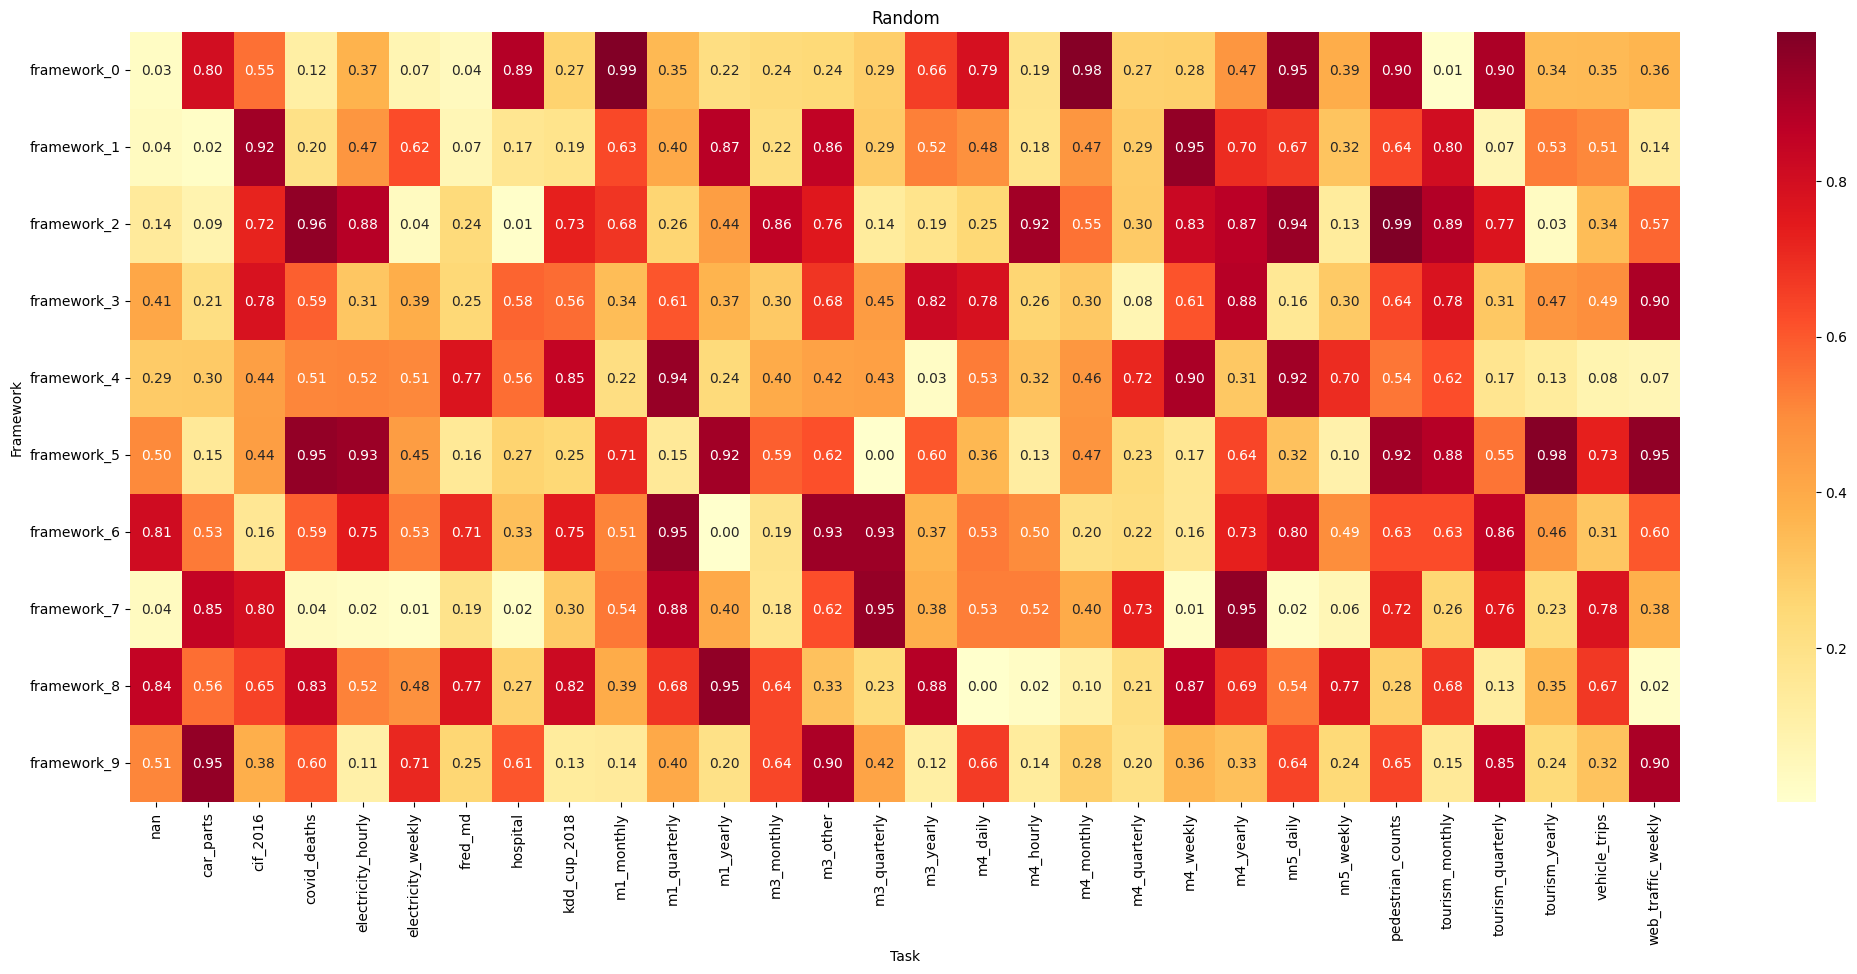

In [145]:
# plot df_random_pivot with heatmap
plot_heatmap(df_random_pivot, "Random", "Task", "Framework", annot_format=".2f")



In [146]:
def calculate_framework_metrics(df):
    """
    Calculate the following metrics for the given dataframe:
    1. Average rescaled MASE (across all tasks) for each framework
    2. Average rank (across all tasks) for each framework
    3. Champion count (number of times a framework had the best performance across all tasks)

    Parameters:
    df (pd.DataFrame): DataFrame containing the rescaled MASE values for each framework and task.

    Returns:
    pd.DataFrame: DataFrame with 'average_rescaled_mase', 'average_rank', and 'champion' for each framework.
    """
    frameworks = df.index
    df_metric = pd.DataFrame(index=frameworks, columns=['average_rescaled_mase', 'average_rank', 'champion'])

    df_metric['average_rescaled_mase'] = df.mean(axis=1)
    df_metric['average_rank'] = df.rank(axis=0, na_option='keep').mean(axis=1)
    df_metric['champion'] = (df.rank(axis=0, method='min', ascending=True) == 1).sum(axis=1)
    
    return df_metric


In [147]:
calculate_framework_metrics(df_mase_pivot)

,average_rescaled_mase,average_rank,champion
framework,,,
NaN,NaN,NaN,0
AutoGluon,1.621280,1.038462,25
SeasonalNaive,2.086139,2.428571,2
TabPFN,2.834911,2.240000,2
